# PCA/SVD Analysis

In this notebook, I process my data and filter it using my SVD algorithm described in my report.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataloaders import *
from scipy import sparse
from scipy.sparse.linalg import svds, eigs
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Import the data

In [2]:
multiomics, target_tags = import_data("../data_csv/rna.csv", '../data_csv/motif.csv', "../data_csv/atac_mat.csv")

Index(['AAACAGCCAATAACGA-4', 'AAACATGCAAGCGATG-1', 'AAACCGAAGGGCTAAA-3',
       'AAACCGCGTACTTCAC-3', 'AAACCGGCACTCGCTC-1', 'AAACGCGCAATGAAGC-2',
       'AAACGCGCAGGAATCG-4', 'AAACGGATCCGCCTCA-2', 'AAACGGATCTAGCGTG-3',
       'AAACGTACAAGGATTA-2',
       ...
       'TTTGTGAAGGCGGATG-3', 'TTTGTGAAGTAAGTGG-1', 'TTTGTGGCACACAATT-3',
       'TTTGTGGCAGGTTATT-3', 'TTTGTGTTCAACCAAC-4', 'TTTGTGTTCAATGACC-4',
       'TTTGTGTTCCCATAAA-1', 'TTTGTGTTCGCCTGTT-4', 'TTTGTGTTCTAAGGAG-1',
       'TTTGTTGGTCCTAAGA-1'],
      dtype='object', length=3900)


In [3]:
atac = pd.read_csv("../data_csv/atac_sparse_csv.csv")
rna = pd.read_csv("../data_csv/rna_sparse_csv.csv")
motif = pd.read_csv("../data_csv/motif.csv", index_col=[0]).T

In [7]:
atac_sparse = sparse.csc_matrix((atac["x"].to_numpy(), (atac["i"].to_numpy()-1, atac["j"].to_numpy()-1)), shape=(71201, 3900)).transpose()
rna_sparse = sparse.csc_matrix((rna["x"].to_numpy(), (rna["i"].to_numpy()-1, rna["j"].to_numpy()-1)), shape=(36597, 3900)).transpose()
print(rna_sparse.shape)
print(atac_sparse.shape)
targets = rna_sparse[:, -6:]
rna_sparse = rna_sparse[:, :-6]
motif_sparse = sparse.csc_matrix(motif.to_numpy())
print(motif_sparse.shape)

(3900, 36597)
(3900, 71201)
(3900, 633)


# Combine and Normalize

SVD requires normalized features to work correctly, so I normalize here.

In [9]:
multiomics_sparse = sparse.hstack((atac_sparse, rna_sparse, motif_sparse))
print(multiomics_sparse.shape)
c = multiomics_sparse.copy()
c.data **= 2
means = multiomics_sparse.mean(0)
meanssquared = np.square(means)
squaredmeans = c.mean(0)
variances = squaredmeans - meanssquared
variances = np.where(variances != 0, variances, np.ones(variances.shape))

(3900, 108425)


In [10]:
multiomics_sparse_shifted = multiomics_sparse-means
divider = sparse.diags(np.asarray(1/variances)[0, :])
multiomics_sparse_normalized = multiomics_sparse_shifted @ divider

# Compute SVD

In [11]:
# Parameters

k = 100
topvals = 100

In [12]:
u, s, vt = svds(multiomics_sparse_normalized, k=k)

In [13]:
print(u.shape)
print(vt.shape)
print(s)

(3900, 100)
(100, 108425)
[ 7866.21333963  7877.82197257  7886.52777461  7892.73424061
  7900.13059714  7900.75865406  7904.14068939  7908.62739499
  7920.73412122  7928.75045305  7934.18627624  7942.20423516
  7944.86611085  7956.60972176  7957.02811073  7966.45897758
  7974.61638031  7975.79034695  7977.85144147  7988.64624918
  7999.50216632  8000.55374076  8010.97578547  8020.31487907
  8029.46431272  8046.05991084  8062.70829258  8091.72299411
  8099.52175847  8102.05704056  8108.79925548  8117.14033113
  8121.45635145  8135.69599106  8149.28511555  8151.05835462
  8179.26583433  8189.36357139  8196.76703834  8208.30062435
  8214.85880125  8217.38262505  8232.17412541  8239.07332659
  8244.3005919   8305.65273759  8309.74385773  8322.41265349
  8348.62980634  8367.66525306  8371.61631699  8385.22886603
  8399.98771847  8426.61487767  8428.07248941  8450.65164412
  8476.71069599  8490.44353021  8496.66667296  8499.13109217
  8517.30170891  8534.26743084  8542.50716991  8558.7453382

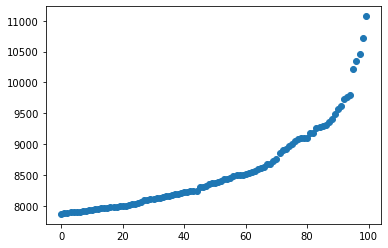

In [14]:
import matplotlib.pyplot as plt
plots = s[-k:]
plt.scatter(np.arange(len(plots)), plots)

A plot of the ranked magnitudes of the singular values. Note the negative indexing as the largest value is always at the end.

### Compute the N top eigenvectors, get their top M indices

In [15]:
# Take top 100 svd vectors (highest singluar values)
eigenvectors = vt[-k:, :]
eigenvectors = np.abs(eigenvectors)
# For each of the top 100, take their highest value entries. 
# These are the most important features for the most important V vectors.
uniquevals = set()
for vector in eigenvectors:
    ind = np.argpartition(vector, -topvals)[-topvals:]
    uniquevals.update(ind.tolist())
ranked_indices = list(uniquevals)
print("Percentage unique: {}".format(len(uniquevals)/(k*topvals)))
print("Unique length: {}, total number of checked values: {}".format(len(uniquevals), k*topvals))

Percentage unique: 0.3789
Unique length: 3789, total number of checked values: 10000


### Calculate the datasets from which the ranked indices come from. Note the lack of any motif data.

In [16]:
npidx = np.array(ranked_indices)

atac_indices = np.arange(0, atac_sparse.shape[1], 1)
rna_indices = np.arange(atac_sparse.shape[1], atac_sparse.shape[1]+rna_sparse.shape[1], 1)
motif_indices = np.arange(atac_sparse.shape[1]+rna_sparse.shape[1], multiomics_sparse.shape[1], 1)

percent_atac = np.sum([npidx[i] in atac_indices for i in range(npidx.shape[0])])/len(ranked_indices)
percent_rna = np.sum([npidx[i] in rna_indices for i in range(npidx.shape[0])])/len(ranked_indices)
percent_motifs = np.sum([npidx[i] in rna_indices for i in range(npidx.shape[0])])/len(ranked_indices)


percent_motifs = np.sum(npidx[npidx in motif_indices])

print(percent_atac)
print(percent_rna)
print(percent_motifs)

best_motif_tags = ["SNAI2", "ELF1", "GABPA", "ETV6", "EHF", "ETV1", "SNAI3", "ETV4", "GATA3"]

0.312219583003431
0.687780416996569
0


C:\Users\alexo\AppData\Local\Temp/ipykernel_11024/2527857600.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  percent_motifs = np.sum(npidx[npidx in motif_indices])


### Format and save to CSV

In [17]:
multiomics_indices = multiomics.drop(target_tags, axis=1).drop(pd.Index(["dataset"]), axis=1)
multiomics_clean = multiomics_indices.iloc[:, ranked_indices]
# multiomics_clean = pd.concat((multiomics_clean, multiomics[best_motif_tags]), axis=1)
multiomics_clean = pd.concat((multiomics_clean, multiomics[target_tags]), axis=1)
multiomics_clean = pd.concat((multiomics_clean, multiomics["dataset"]), axis=1)

print(multiomics_clean.shape)

(3900, 3797)


In [18]:
multiomics_clean.to_csv("../data_csv/multiomics_svd_{}x{}_final.csv".format(k, topvals), index=None)

# (DEPRECATED) PCA Biplot

In [8]:
multiomics_sparse

<3900x108425 sparse matrix of type '<class 'numpy.float64'>'
	with 22902952 stored elements in COOrdinate format>

In [31]:
def myplot(y, score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in tqdm(range(n)):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [32]:
# topvals = 26
component0 = 0
component1 = 2

svd = TruncatedSVD(n_components=10)
multiomics_svd = svd.fit_transform(multiomics_sparse_normalized)

print(multiomics_svd.shape)
print(svd.components_.shape)

(3900, 10)
(10, 108425)


100%|████████████████████████████████████████████████████████████████████████| 108425/108425 [01:09<00:00, 1559.82it/s]


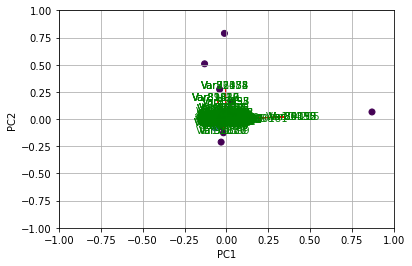

In [24]:
myplot(targets[:, 5].toarray(), multiomics_svd[:,component0:component1],np.transpose(svd.components_[component0:component1,:]))
plt.show()

In [33]:
topcoeffs = svd.components_[component0:component1, :]
topnorms = np.linalg.norm(topcoeffs, axis=0)

ranked = np.argpartition(topnorms, -topvals)[-topvals:]
ranked = (topnorms > 0.1).nonzero()[0]

print(ranked)
print(topnorms[ranked])

[ 77841  79194  80109  80351  84152  84881  85034  92418  94634  97395
  98995 100180 101427 101897 104214 105064 105556 106649]
[0.17863099 0.3437387  0.3437387  0.3437387  0.3437387  0.17751049
 0.3437387  0.18061369 0.34281812 0.11909921 0.17839728 0.18035403
 0.17744514 0.34281812 0.3437387  0.17809432 0.34281812 0.34281812]


In [34]:
multiomics_indices = multiomics.drop(target_tags, axis=1).drop(pd.Index(["dataset"]), axis=1)
multiomics_clean = multiomics_indices.iloc[:, ranked]
multiomics_clean = pd.concat((multiomics_clean, multiomics[target_tags]), axis=1)
multiomics_clean = pd.concat((multiomics_clean, multiomics["dataset"]), axis=1)
print(multiomics_clean.shape)

print(component0)
print(component1)
print(len(ranked))

(3900, 26)
0
2
18


In [30]:
multiomics_clean.to_csv("../data_csv/multiomics_svd_biplot_{}_{}_{}.csv".format(component0, component1, len(ranked)), index=None)